# NN4
Tymoteusz Urban

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import copy
from sklearn.metrics import f1_score
from tqdm import tqdm

In [87]:
def early_stopping(validation_losses, window_size, k):
    if len(validation_losses) < window_size * k:
        return False
    else:
        averages = [sum(validation_losses[i:i+window_size]) / window_size for i in range(0, len(validation_losses) - window_size + 1)]
        last_k_averages = averages[-k:]
        return all(last_k_averages[i] < last_k_averages[i+1] for i in range(k-1))

In [122]:
class NeuralNetwork:
    
    """
    Implementation of multi layer perceptron

    Attributes
    -----------
    model_type : str
        model type, regressor or classifier
    layers : List
        list of layer sizes
    num_layers : int
        number of layers
    init_function : func
        
    """
    
    def __init__(self, layers, initalization='xavier', model_type='regression', weights=None, biases=None, activations=None):
        """
        activations - list of available functions: 'sigmoid', 'linear', 'tanh', 'relu', 'softmax' ('softmax' can be used only on the last layer)
        initialization - available types: 'xavier', 'he', 'uniform'
        model_type - available types: 'regression', 'classification'
        """        
        self.layers = layers
        self.num_layers = len(layers)
        
        initialization_functions = {
            'xavier': self.xavier_init,
            'he': self.he_init,
            'uniform': self.uniform_init
        }
        self.init_function = initialization_functions.get(initalization)
        
        assert model_type in ['regression', 'classification']
        self.model_type = model_type
        
        if weights is None:
            self.weights = [self.init_function(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [self.init_function(layers[i]) for i in range(1, self.num_layers)]
        else:
            self.biases = biases
        
        if activations is None:
            if self.model_type == 'regression':
                self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['linear']
            elif self.model_type == 'classification':
                self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['softmax']
        else:
            self.activations = activations
        
        self.velocities_weights = [self.zeros_init(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        self.velocities_biases = [self.zeros_init(layers[i]) for i in range(1, self.num_layers)]
        
        activation_functions = {
            'sigmoid': self._sigmoid,
            'linear': self._linear,
            'softmax': self._softmax,
            'tanh': self._tanh,
            'relu': self._relu
        }
        self.activation_funcs = list(map(lambda x: activation_functions.get(x), self.activations))
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _linear(self, z):
        return z
    
    def _tanh(self, z):
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    
    def _relu(self, z):
        return np.maximum(z, 0)
    
    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / exp_z.sum(axis=1, keepdims=True)
    
    def tanh_derivative(self, a):
        """calculates tanh'(z) where a = tanh(z)"""
        return 1 - (a ** 2)
    
    def sigmoid_derivative(self, a):
        """calculates sigm'(z) where a = sigm(z)"""
        return a * (1-a)
    
    def relu_derivative(self, z):
        return np.maximum(0, np.sign(z))
    
    def xavier_init(self, n_in, n_out=None):
        if n_out is None:
            n_out = n_in
            variance = 1 / n_out
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_out)
        variance = 2 / (n_in + n_out)
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
        
    def he_init(self, n_in, n_out=None):
        if n_out is None:
            variance = 2 / n_in
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_in)
        variance = 2 / n_in
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
    
    def zeros_init(self, n_in, n_out=None):
        if n_out is None:
            return np.zeros(n_in)
        return np.zeros((n_in, n_out))
    
    def uniform_init(self, n_in, n_out=None):
        if n_out is None:
            return np.random.uniform(0, 1, n_in)
        return np.random.uniform(0, 1, (n_in, n_out))
    
    def feedforward(self, a, return_activations=False):
        if return_activations:
            activations = [a]
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
                activations.append(a)
            return activations
        else:
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
            return a
    
    def predict(self, X, label=False):
        """ if to use label_predictions function """
        if label:
            return label_predictions(self.feedforward(X))
        else:
            return self.feedforward(X)
    
    def mse(self, X, y, resize=False, denormalize=None):
        """
        first predictions are made, then denormalized and then mse is calculated
        
        denormalize - a tuple (mean, std)
        """
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
        predictions = self.predict(X)
        if denormalize:
            predictions = destandardize_data(predictions, denormalize)
        return np.mean((predictions - y) ** 2)
    
    def f1_score(self, X, y_true, average='weighted'):
        """
        calculates f1 score. 
        y_true : 2 dimensional array with probabilities
        average: 'weighted', 'macro'
        """
        predictions = self.predict(X)
        y_pred = label_predictions(predictions)
        y_true = label_predictions(y_true)
        f1 = f1_score(y_true, y_pred, average='weighted')
        return f1

    def cross_entropy(self, X, y):
        """ Calculates cross entropy loss """
        predictions = self.predict(X)
        epsilon = 1e-9  # Small constant to avoid taking the logarithm of zero
        return -np.mean(np.sum(y * np.log(predictions + epsilon), axis=1))
    
    def loss(self, X, y, resize=False, denormalize=None, test=False):
        """ returns appriopriate loss """
        if self.model_type == 'regression':
            return self.mse(X, y, resize=resize, denormalize=denormalize)
        elif self.model_type == 'classification':
            if test:
                return self.f1_score(X, y)
            else:
                return self.cross_entropy(X, y)
    
    def plot_classes(self, data):
        """ plots predicted classes for classifcation data. plot based only on first two columns of passed data. """
        colors = self.predict(data, label=True)
        sns.scatterplot(x=data[:,0], y=data[:,1], hue=colors)
    
    def backward(self, X, y, l2_lambda=None):
        """backpropagation, returns partial derevatives"""
        # feedforward
        activations = self.feedforward(X, return_activations=True)
        deltas = [None] * len(self.weights)
        # output error
        if self.activations[-1] == "softmax":
            deltas[-1] = activations[-1] - y 
        elif self.activations[-1] == "linear": # linear
            deltas[-1] = activations[-1] - y
        elif self.activations[-1] == "sigmoid":
            deltas[-1] = (activations[-1] - y) * self.sigmoid_derivative(activations[-1])
        elif self.activations[-1] == "relu" or self.activations[-1] == "tanh":
            raise AssertionError('tanh and relu cant be used on the last layer')
        # calculate neurons' errors using backpropagation 
        for i in reversed(range(len(deltas) - 1)):
            if self.activations[i] == "sigmoid":
                # calculate error delta_l = delta_{l+1} x w_{l+1} * sigmoid'(a_{l})
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            elif self.activations[i] == "linear":
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T)
            elif self.activations[i] == "relu":
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * self.relu_derivative(activations[i+1])
            elif self.activations[i] == "tanh":    
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * self.tanh_derivative(activations[i+1])
            elif self.activations[i] == "softmax":
                raise AssertionError("softmax can be used only on the last layer")
        L = len(self.weights)
        weights_gradient = [None] * L
        biases_gradient = [None] * L
        # calculate partial derevatives of cost function
        for i in range(L):
            # activations array is longer (so activations[l] in reality is a_{l-1})
            weights_gradient[i] = np.dot(activations[i].T, deltas[i])
            biases_gradient[i] = np.sum(deltas[i], axis=0)
            
            if l2_lambda is not None:
                n = len(self.weights[i])
                # weights_gradient[i] = weights_gradient[i] + (l2_lambda / n) * np.square(self.weights[i])
                weights_gradient[i] = weights_gradient[i] + l2_lambda * np.square(self.weights[i] / np.sqrt(n))
            
        return weights_gradient, biases_gradient
        
    def update_weights(self, X, y, learning_rate, optimize=None, optimize_param=0.9, l2_lambda=None):
        """
        updates weights using gradient descent
        """
        m = len(X)
        weights_gradient, biases_gradient = self.backward(X, y, l2_lambda)
        for i in range(len(self.weights)):
            
            if optimize is None:
                self.weights[i] = self.weights[i] - (learning_rate/m) * weights_gradient[i]
                self.biases[i] = self.biases[i] - (learning_rate/m) * biases_gradient[i]
            
            elif optimize == 'moment':
                self.velocities_weights[i] = weights_gradient[i] + self.velocities_weights[i] * optimize_param
                self.velocities_biases[i] = biases_gradient[i] + self.velocities_biases[i] * optimize_param
            
                self.weights[i] = self.weights[i] - (learning_rate/m) * self.velocities_weights[i]
                self.biases[i] = self.biases[i] - (learning_rate/m) * self.velocities_biases[i]            
            
            elif optimize == 'rmsprop':
                self.velocities_weights[i] = optimize_param * self.velocities_weights[i] + (1-optimize_param) * (weights_gradient[i]**2)
                self.velocities_biases[i] = optimize_param * self.velocities_biases[i] + (1-optimize_param) * (biases_gradient[i]**2)
                
                self.weights[i] = self.weights[i] - (learning_rate/m) * (weights_gradient[i]/np.sqrt(self.velocities_weights[i]))
                self.biases[i] = self.biases[i] - (learning_rate/m) * (biases_gradient[i]/np.sqrt(self.velocities_biases[i]))
    
    def create_batches(self, X, y, batch_size):
        """ creates batches """
        N = len(X)
        combined_data = list(zip(X, y))
        np.random.shuffle(combined_data)

        X_shuffled = np.array(list(zip(*combined_data))[0])
        y_shuffled = np.array(list(zip(*combined_data))[1])

        X_mini_batches = [X_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        y_mini_batches = [y_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        return X_mini_batches, y_mini_batches
        
    def train(self, X, y, learning_rate=0.001, epochs=10000, batch_size=None, return_history=False, window_size=1,
              optimize=None, optimize_param=0.9, l2_lambda=None, val_stopping_k=None, test_metric='f1', X_val=None, y_val=None,
              X_test=None, y_test=None, cutoff=None, cutoff_inverse=False, resize=False, denormalize=None, 
              info_interval=500, mute_print=False):
        """
        To test and print MSE on testset, X_test and y_test need to be provided
        To set early stopping, provide cutoff (and test sets)
        early_stopping: stop when test loss is lower (or above) the cutoff
        val_stopping: stop when val loss starts to rise   
        denormalize: a tuple (mean, std) for denormalizing target for calculating mse
        info_interval: number of epochs between logging, set to None to turn off console output
        optimize: 'moment' or 'rmsprop'
        test_metric: 'f1' or 'entropy'
        window_size: how many values to we average in validation stopping
        """
        assert optimize is None or optimize in ['moment', 'rmsprop'], f"optimize should be None or in ['moment', 'rmsprop']"
        assert test_metric in ['f1', 'entropy']
        
        # setting flags
        test_mse = False
        if X_test is not None and y_test is not None:
            test_mse = True
        early_stopping = False
        if test_mse and cutoff is not None:
            early_stopping = True
            
        test_val = False
        if X_val is not None and y_val is not None:
            test_val = True
        val_stopping = False
        if test_val and val_stopping_k is not None:
            k = val_stopping_k
            val_stopping = True
        
        # resizing
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
            if test_mse:
                X_test = X_test.to_numpy().reshape(-1, 1)
                y_test = y_test.to_numpy().reshape(-1, 1)
            
        if batch_size is None:
            batch_size = len(X)
        
        # denormalizing for testing
        y_mse = y
        if denormalize is not None:
            y_mse = destandardize_data(y, denormalize)
            
        history = History()
        
        for epoch in range(1, epochs+1):
            
            # mini batch
            if batch_size < len(X):
                batches_x, batches_y = self.create_batches(X, y, batch_size)
                for i in range(len(batches_x)):
                    self.update_weights(batches_x[i], batches_y[i], learning_rate, optimize, optimize_param, l2_lambda)
            else:
                self.update_weights(X, y, learning_rate, optimize, optimize_param, l2_lambda)
            
            # logging
            if info_interval is not None and epoch % info_interval == 0:
                loss = self.loss(X, y_mse, denormalize=denormalize)
                history.loss.append(loss)
                history.loss_epochs.append(epoch)
                training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                if test_mse:
                    if test_metric == 'f1':
                        loss_test = self.loss(X_test, y_test, denormalize=denormalize, test=True)   
                        history.test_loss.append(loss_test)
                        training_info += f" F1 score = {round(loss_test, 3)}"
                    elif test_metric == 'entropy':
                        loss_test = self.loss(X_test, y_test, denormalize=denormalize)   
                        history.test_loss.append(loss_test)
                        training_info += f" test loss = {round(loss_test, 3)}"
                if :
                    loss_val = self.loss(X_val, y_val, denormalize=denormalize)
                    history.val_loss.append(loss_val)
                    training_info += f" Val loss = {round(loss_val, 3)}"
                if not mute_print:
                    print(training_info)
            
            history.weights.append(copy.deepcopy(self.weights))
            history.biases.append(copy.deepcopy(self.biases))
            
            if val_stopping:
                loss_val = self.loss(X_val, y_val, denormalize=denormalize)   
                if info_interval is not None and epoch % info_interval != 0:
                    history.val_loss.append(loss_val)
                if len(history.val_loss) > k * window_size:
                    
                    if window_size > 1:
                        averages = [sum(history.val_loss[i:i+window_size]) / window_size for i in range(0, len(history.val_loss) - window_size + 1)]
                        last_k_averages = averages[-k:]
                        if all(last_k_averages[i] < last_k_averages[i+1] for i in range(k-1)):
                            print(f'validation stopping: {loss_val}')
                            break
                    else:
                        last_k_losses = history.val_loss[-k:]
                        if all(last_k_losses[i] < last_k_losses[i+1] for i in range(k-1)):
                            print(f'validation stopping: {loss_val}')
                            break
            # early stopping
            elif early_stopping:
                loss_es = self.loss(X_test, y_test, denormalize=denormalize, test=True)
                if (loss_es <= cutoff and not cutoff_inverse) or (loss_es >= cutoff and cutoff_inverse):
                    loss = self.loss(X, y_mse, denormalize=denormalize)    
                    training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                    training_info += f" Test loss = {round(loss_es, 3)}"
                    print(training_info)
                    break
                
            
        if return_history:
            history.model_type = self.model_type
            return history

def standardize_data(X):
    """
    returns:
    X_new - standardized X
    a tuple (mean, std) - normal distribution parameters from X for destandarizing
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_new = (X - mean) / std
    return X_new, (mean, std)

def destandardize_data(X, parameters):
    """parameters: a tuple (mean, std)"""
    return X * parameters[1] + parameters[0]


def label_predictions(y_pred, class_order=None):
    """
    y_pred : 2 dimensional array
    class_order : default [..., 2, 1, 0]
    """
    if class_order is None:
        class_order = np.array(range(len(y_pred[0])))
    max_indices = np.argmax(y_pred, axis=1)
    return class_order[max_indices]

def one_hot_encode(y):
    """ y : pd.Series """
    return pd.get_dummies(y, dtype=int).to_numpy()

def decode_array(array):
    """ decodes one hot encoded array """
    decoded_indices = np.argmax(array, axis=1)
    return decoded_values.tolist()

def plot_classes(data, colors):
    sns.scatterplot(x=data[:,0], y=data[:,1], hue=colors)

def mse(y_true, y_pred):
    """ calculated mse """
    return np.mean((y_pred - y_true) ** 2)

def cross_entropy(y_true, y_pred):
    """ calculates cross entropy loss, y_true and y_pred should be 2-dimensional """
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
class History:
    """
    Class which attributes are weights from all training epochs 
    and loss for chosen loss_epochs (usually epochs with some interval)
    """
    
    def __init__(self):
        self.weights = []
        self.biases = []
        self.loss = []
        self.test_loss = []
        self.loss_epochs = []
        self.val_loss = []
        self.model_type = 'regression'
    
    def plot_weights(self, layer, bias=False, return_plot=False):
        """
        layer - integer, index of weights vector
        if to plot bias instead of weights 
        """
        weights = []
        weights_type = 'Weights'
        if bias:
            weights_type = 'Biases'
            for epoch in self.biases:
                weights.append(epoch[layer].flatten())
        else:
            for epoch in self.weights:
                weights.append(epoch[layer].flatten())

        weights = np.array(weights)
        for i in range(weights.shape[1]):
            w_y = weights[:,i]
            plt.plot(range(len(self.weights)), w_y)
            
        plt.xlabel('Epochs')
        plt.title(f'{weights_type} values vs epochs at layer {layer}')
        if return_plot:
            return plt
        else:
            plt.show()
        
    def plot_loss(self, loss_type='train', return_plot=False, settings=''):
        """
        loss_type: 'train', 'test', 'val'
        """
        if loss_type=='test':
            plt.plot(self.loss_epochs, self.test_loss, settings)
            plt.title('Test loss history')
        elif loss_type=='train':
            plt.plot(self.loss_epochs, self.loss, settings)
            plt.title('Training loss history')
        elif loss_type == 'val':
            plt.plot(list(range(len(self.val_loss))), self.val_loss, settings)
        plt.xlabel('Epochs')
        if self.model_type == 'classification':
            plt.ylabel('Cross Entropy')
        else: 
            plt.ylabel('MSE')
        if return_plot:
            return plt
        else:
            plt.show()

## Eksperymenty

In [5]:
'''
multimodal-sparse
rings4-sparse
rings3-balance
xor3-balance
'''

'\nmultimodal-sparse\nrings4-sparse\nrings3-balance\nxor3-balance\n'

In [61]:
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split

In [23]:
activation_types = ['tanh', 'relu', 'sigmoid']
colors = ['b', 'g', 'y']
legend_handles = [Patch(color=color, label=label) for label, color in zip(activation_types, colors)]

def generate_activations(num_layers, activation_type, regression=False):
    last_layer = 'softmax'
    if regression:
        last_layer = 'linear'
    return [activation_type] * num_layers + [last_layer]

### rings 3

In [79]:
rings3_test = pd.read_csv("../dane/classification/rings3-balance-test.csv")
rings3_train = pd.read_csv("../dane/classification/rings3-balance-training.csv")

In [62]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to

In [80]:
X_train = rings3_train[['x', 'y']].to_numpy()
y_train = one_hot_encode(rings3_train['c'])
X_val, X_test, y_val, y_test = train_test_split(rings3_test[['x', 'y']].to_numpy(), one_hot_encode(rings3_test['c']),
                                                test_size=0.5, random_state=42)

- 2 hidden layers

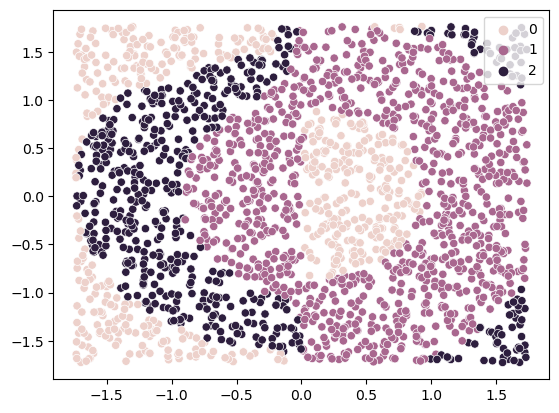

In [60]:
nn3.plot_classes(X_test3)

In [113]:
nn3 = NeuralNetwork([2,10,10,3], model_type='classification')
X_train3, _ = standardize_data(X_train)
X_test3, _ = standardize_data(X_test)
X_val3, _ = standardize_data(X_val)
history3 = nn3.train(X_train3, y_train, learning_rate=0.01, info_interval=200, epochs=10000, batch_size=50, val_stopping_k=10,
    X_test=X_test3, y_test=y_test, optimize='moment', return_history=True, X_val=X_val3, y_val=y_val, window_size=10)

Epoch 200: Loss = 0.435 F1 score = 0.428 Val loss = 1.591
Epoch 400: Loss = 0.188 F1 score = 0.574 Val loss = 1.22
Epoch 600: Loss = 0.137 F1 score = 0.646 Val loss = 1.051
Epoch 800: Loss = 0.112 F1 score = 0.673 Val loss = 0.928
Epoch 1000: Loss = 0.116 F1 score = 0.682 Val loss = 0.909
Epoch 1200: Loss = 0.076 F1 score = 0.711 Val loss = 0.695
Epoch 1400: Loss = 0.07 F1 score = 0.735 Val loss = 0.679
Epoch 1600: Loss = 0.077 F1 score = 0.78 Val loss = 0.544
Epoch 1800: Loss = 0.051 F1 score = 0.791 Val loss = 0.566
Epoch 2000: Loss = 0.05 F1 score = 0.795 Val loss = 0.591
Epoch 2200: Loss = 0.045 F1 score = 0.808 Val loss = 0.558
Epoch 2400: Loss = 0.046 F1 score = 0.823 Val loss = 0.504
Epoch 2600: Loss = 0.045 F1 score = 0.819 Val loss = 0.531
Epoch 2800: Loss = 0.039 F1 score = 0.817 Val loss = 0.576
Epoch 3000: Loss = 0.038 F1 score = 0.825 Val loss = 0.521
Epoch 3200: Loss = 0.045 F1 score = 0.822 Val loss = 0.561
Epoch 3400: Loss = 0.057 F1 score = 0.814 Val loss = 0.7
Epoch 3

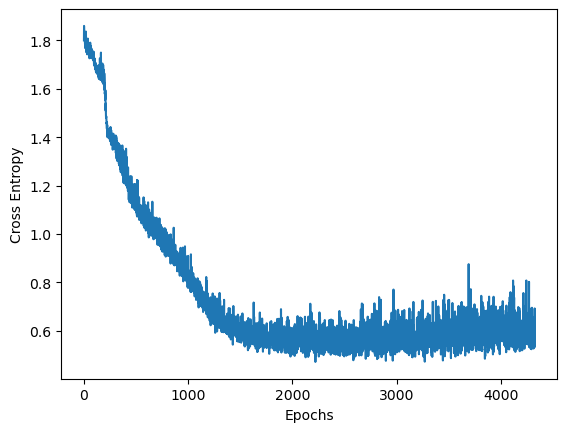

In [114]:
history3.plot_loss(loss_type='val')

In [126]:
nn3 = NeuralNetwork([2,10,10,3], model_type='classification')
X_train3, _ = standardize_data(X_train)
X_test3, _ = standardize_data(X_test)
X_val3, _ = standardize_data(X_val)
history3 = nn3.train(X_train3, y_train, learning_rate=0.01, info_interval=200, epochs=10000, batch_size=50,
    X_test=X_test3, y_test=y_test, optimize='moment', return_history=True, l2_lambda=0.001, test_metric='entropy')

Epoch 200: Loss = 0.554 test loss = 1.613
Epoch 400: Loss = 0.452 test loss = 1.531
Epoch 600: Loss = 0.175 test loss = 1.074
Epoch 800: Loss = 0.115 test loss = 0.783
Epoch 1000: Loss = 0.087 test loss = 0.655
Epoch 1200: Loss = 0.074 test loss = 0.584
Epoch 1400: Loss = 0.069 test loss = 0.54
Epoch 1600: Loss = 0.07 test loss = 0.516
Epoch 1800: Loss = 0.051 test loss = 0.469
Epoch 2000: Loss = 0.047 test loss = 0.468
Epoch 2200: Loss = 0.044 test loss = 0.435
Epoch 2400: Loss = 0.041 test loss = 0.431
Epoch 2600: Loss = 0.041 test loss = 0.433
Epoch 2800: Loss = 0.032 test loss = 0.447
Epoch 3000: Loss = 0.034 test loss = 0.483
Epoch 3200: Loss = 0.027 test loss = 0.46
Epoch 3400: Loss = 0.028 test loss = 0.478
Epoch 3600: Loss = 0.026 test loss = 0.479
Epoch 3800: Loss = 0.025 test loss = 0.48
Epoch 4000: Loss = 0.022 test loss = 0.515
Epoch 4200: Loss = 0.019 test loss = 0.508
Epoch 4400: Loss = 0.019 test loss = 0.528
Epoch 4600: Loss = 0.018 test loss = 0.54
Epoch 4800: Loss = 0

C:\Users\tymoteusz.urban\AppData\Local\Temp\ipykernel_4924\2069983563.py:68: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 7800: Loss = 0.048 test loss = 0.702


C:\Users\tymoteusz.urban\AppData\Local\Temp\ipykernel_4924\2069983563.py:230: RuntimeWarning: overflow encountered in square
  weights_gradient[i] = weights_gradient[i] + l2_lambda * np.square(self.weights[i] / np.sqrt(n))


Epoch 8000: Loss = nan test loss = nan
Epoch 8200: Loss = nan test loss = nan
Epoch 8400: Loss = nan test loss = nan
Epoch 8600: Loss = nan test loss = nan
Epoch 8800: Loss = nan test loss = nan
Epoch 9000: Loss = nan test loss = nan
Epoch 9200: Loss = nan test loss = nan
Epoch 9400: Loss = nan test loss = nan
Epoch 9600: Loss = nan test loss = nan
Epoch 9800: Loss = nan test loss = nan
Epoch 10000: Loss = nan test loss = nan


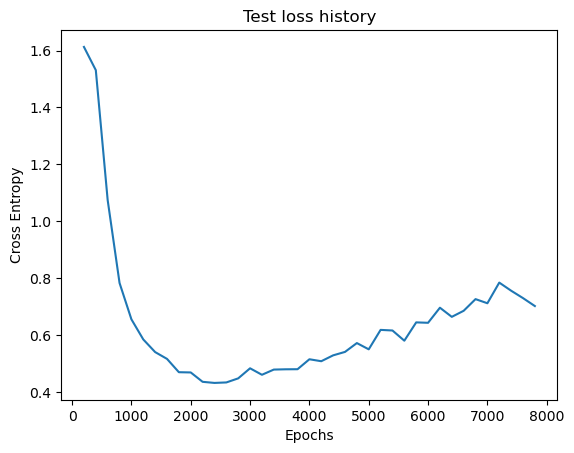

In [127]:
history3.plot_loss(loss_type='test')

In [121]:
nn3 = NeuralNetwork([2,10,10,3], model_type='classification')
X_train3, _ = standardize_data(X_train)
X_test3, _ = standardize_data(X_test)
X_val3, _ = standardize_data(X_val)
history3 = nn3.train(X_train3, y_train, learning_rate=0.01, info_interval=200, epochs=10000, batch_size=50, val_stopping_k=10,
    X_test=X_test3, y_test=y_test, optimize='moment', return_history=True, l2_lambda=0.001, X_val=X_val3, y_val=y_val,
                     window_size=20)

Epoch 200: Loss = 0.496 F1 score = 0.405 Val loss = 1.704
Epoch 400: Loss = 0.433 F1 score = 0.412 Val loss = 1.536
Epoch 600: Loss = 0.175 F1 score = 0.581 Val loss = 1.093
Epoch 800: Loss = 0.126 F1 score = 0.635 Val loss = 0.964
Epoch 1000: Loss = 0.093 F1 score = 0.685 Val loss = 0.799
Epoch 1200: Loss = 0.077 F1 score = 0.731 Val loss = 0.683
Epoch 1400: Loss = 0.07 F1 score = 0.773 Val loss = 0.62
validation stopping: 0.6386264615908599


- 3 hidden layers

3it [02:38, 52.92s/it]


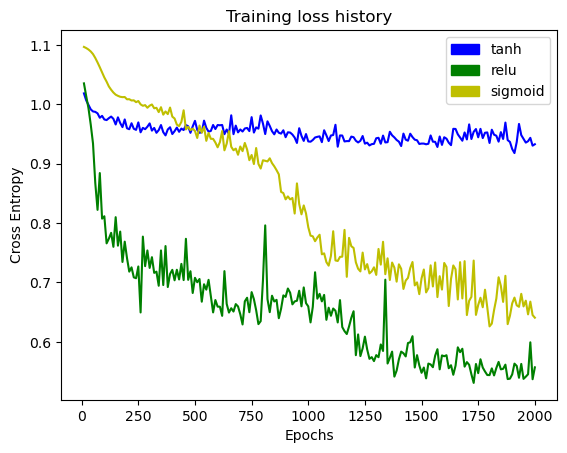

In [46]:
for act_type, color in tqdm(zip(activation_types, colors)):
    losses = []
    for i in range(5):
        nn3 = NeuralNetwork([2,5,5,5,3], model_type='classification', activations=generate_activations(3, act_type))
        history3 = nn3.train(X_train, y_train, learning_rate=0.01, info_interval=10, epochs=2000, batch_size=125,
            X_test=X_test, y_test=y_test, optimize='moment', return_history=True, mute_print=True)
        losses.append(np.array(history3.loss))
    history3.loss = np.mean(losses, axis=0)
    history3.plot_loss(return_plot=True, settings=color)
plt.legend(handles=legend_handles)

### rings 5

In [48]:
rings5_test = pd.read_csv("../dane/classification/rings5-regular-test.csv")
rings5_train = pd.read_csv("../dane/classification/rings5-regular-training.csv")

In [50]:
X_train = rings5_train[['x', 'y']].to_numpy()
y_train = one_hot_encode(rings5_train['c'])
X_test = rings5_test[['x', 'y']].to_numpy()
y_test = one_hot_encode(rings5_test['c'])- 1 hidden layer

- 1 hidden layer

3it [01:36, 32.01s/it]


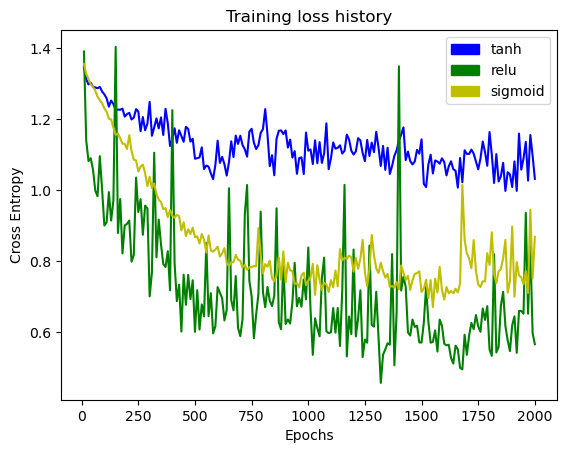

In [54]:
for act_type, color in tqdm(zip(activation_types, colors)):
    losses = []
    for i in range(5):
        nn5 = NeuralNetwork([2,10,5], model_type='classification', activations=generate_activations(1, act_type))
        history5 = nn5.train(X_train, y_train, learning_rate=0.01, info_interval=10, epochs=2000, batch_size=125,
            X_test=X_test, y_test=y_test, optimize='moment', return_history=True, mute_print=True)
        losses.append(np.array(history5.loss))
    history5.loss = np.mean(losses, axis=0)
    history5.plot_loss(return_plot=True, settings=color)
plt.legend(handles=legend_handles)

- 2 hidden layers

3it [01:55, 38.44s/it]


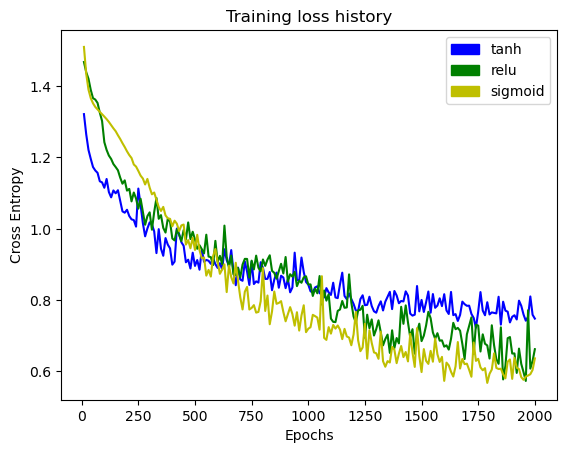

In [55]:
for act_type, color in tqdm(zip(activation_types, colors)):
    losses = []
    for i in range(5):
        nn5 = NeuralNetwork([2,10,10,5], model_type='classification', activations=generate_activations(2, act_type))
        history5 = nn5.train(X_train, y_train, learning_rate=0.01, info_interval=10, epochs=2000, batch_size=125,
            X_test=X_test, y_test=y_test, optimize='moment', return_history=True, mute_print=True)
        losses.append(np.array(history5.loss))
    history5.loss = np.mean(losses, axis=0)
    history5.plot_loss(return_plot=True, settings=color)
plt.legend(handles=legend_handles)- 1 hidden layer

- 3 hidden layers

3it [02:16, 45.56s/it]


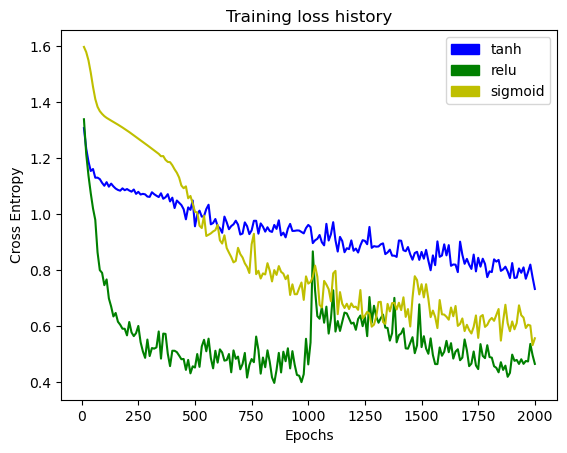

In [56]:
for act_type, color in tqdm(zip(activation_types, colors)):
    losses = []
    for i in range(5):
        nn5 = NeuralNetwork([2,10,10,10,5], model_type='classification', activations=generate_activations(3, act_type))
        history5 = nn5.train(X_train, y_train, learning_rate=0.01, info_interval=10, epochs=2000, batch_size=125,
            X_test=X_test, y_test=y_test, optimize='moment', return_history=True, mute_print=True)
        losses.append(np.array(history5.loss))
    history5.loss = np.mean(losses, axis=0)
    history5.plot_loss(return_plot=True, settings=color)
plt.legend(handles=legend_handles)- 1 hidden layer

### multimodal-large

In [57]:
multi_test = pd.read_csv("../dane/regression/multimodal-large-test.csv")
multi_train = pd.read_csv("../dane/regression/multimodal-large-training.csv")

In [74]:
X_train = multi_train['x']
y_train = multi_train['y']
X_test = multi_test['x']
y_test = multi_test['y']

- 1 hidden layer

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.10s/it]
1it [02:15, 135.50s/it]
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.40s/it]
2it [04:22, 130.49s/it]
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.95s/it]
3it [06:37, 132.42s/it]


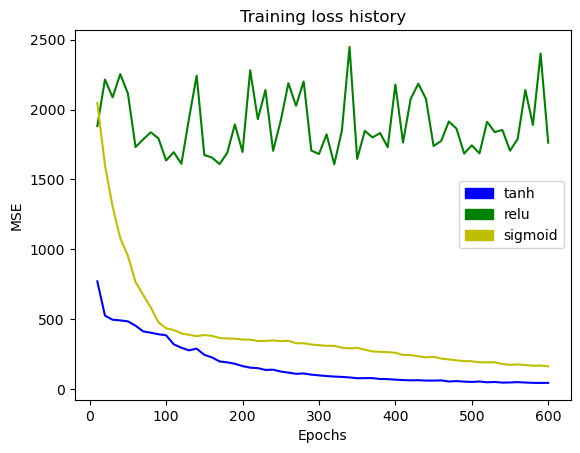

In [78]:
for act_type, color in tqdm(zip(activation_types, colors)):
    losses = []
    y_norm_modal, parameters_modal = standardize_data(y_train)
    for i in range(5):
        nnm = NeuralNetwork([1,10,1], model_type='regression', activations=generate_activations(1, act_type, regression=True))
        historym = nnm.train(X_train, y_norm_modal, learning_rate=0.1, info_interval=10, epochs=600, batch_size=125,
            optimize='moment', return_history=True, resize=True, denormalize=parameters_modal, mute_print=True)
        losses.append(np.array(historym.loss))
    historym.loss = np.mean(losses, axis=0)
    historym.plot_loss(return_plot=True, settings=color)
plt.legend(handles=legend_handles)- 1 hidden layer

- 2 hidden layers

3it [07:07, 142.40s/it]


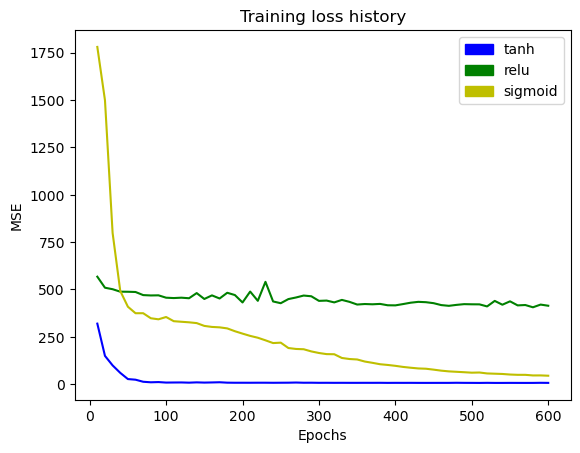

In [79]:
for act_type, color in tqdm(zip(activation_types, colors)):
    losses = []
    y_norm_modal, parameters_modal = standardize_data(y_train)
    for i in range(5):
        nnm = NeuralNetwork([1,10,10,1], model_type='regression', activations=generate_activations(2, act_type, regression=True))
        historym = nnm.train(X_train, y_norm_modal, learning_rate=0.1, info_interval=10, epochs=600,- 1 hidden layer batch_size=125,
            optimize='moment', return_history=True, resize=True, denormalize=parameters_modal, mute_print=True)
        losses.append(np.array(historym.loss))
    historym.loss = np.mean(losses, axis=0)
    historym.plot_loss(return_plot=True, settings=color)
plt.legend(handles=legend_handles)

- 3 hidden layers

3it [08:25, 168.41s/it]


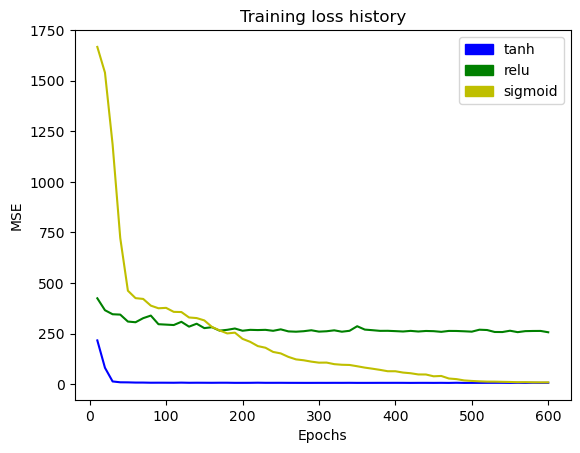

In [80]:
for act_type, color in tqdm(zip(activation_types, colors)):
    losses = []
    y_norm_modal, parameters_modal = standardize_data(y_train)
    for i in range(5):
        nnm = NeuralNetwork([1,10,10,10,1], model_type='regression', activations=generate_activations(3- 1 hidden layer, act_type, regression=True))
        historym = nnm.train(X_train, y_norm_modal, learning_rate=0.1, info_interval=10, epochs=600, batch_size=125,
            optimize='moment', return_history=True, resize=True, denormalize=parameters_modal, mute_print=True)
        losses.append(np.array(historym.loss))
    historym.loss = np.mean(losses, axis=0)
    historym.plot_loss(return_plot=True, settings=color)
plt.legend(handles=legend_handles)

### steps-large

In [81]:
steps_test = pd.read_csv("../dane/regression/steps-large-test.csv", index_col=0)
steps_train = pd.read_csv("../dane/regression/steps-large-training.csv", index_col=0)

In [ ]:
X_train = multi_train['x']
y_train = multi_train['y']
X_test = multi_test['x']
y_test = multi_test['y']

- 1 hidden layer

3it [09:35, 192.00s/it]


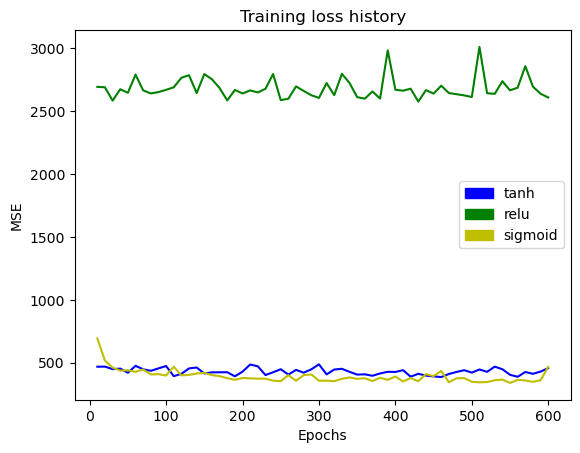

In [84]:
for act_type, color in tqdm(zip(activation_types, colors)):
    losses = []
    y_norm_steps, parameters_steps = standardize_data(y_train)
    for i in range(5):
        nns = NeuralNetwork([1,5,1], model_type='regression', activations=generate_activations(1, act_type, regression=True))
        historys = nns.train(X_train, y_norm_steps, learning_rate=0.1, info_interval=10, epochs=600, batch_size=25,
            optimize='moment', return_history=True, resize=True, denormalize=parameters_steps, mute_print=True)
        losses.append(np.array(historys.loss))
    historys.loss = np.mean(losses, axis=0)
    historys.plot_loss(return_plot=True, settings=color)
plt.legend(handles=legend_handles)

- 2 hidden layers

3it [10:54, 218.06s/it]


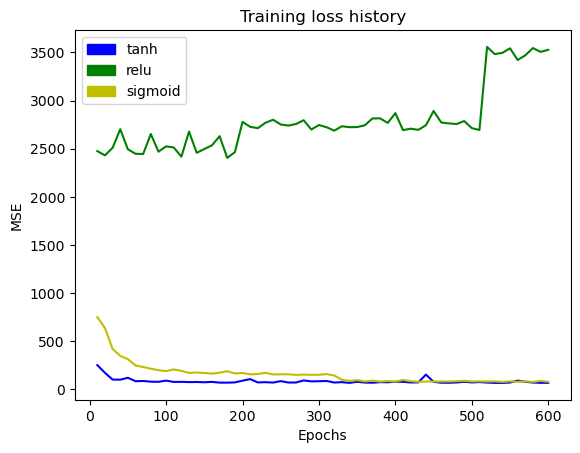

In [88]:
for act_type, color in tqdm(zip(activation_types, colors)):
    losses = []
    y_norm_steps, parameters_steps = standardize_data(y_train)
    for i in range(5):
        nns = NeuralNetwork([1,5,5,1], model_type='regression', activations=generate_activations(2, act_type, regression=True))
        historys = nns.train(X_train, y_norm_steps, learning_rate=0.1, info_interval=10, epochs=600, batch_size=25,
            optimize='moment', return_history=True, resize=True, denormalize=parameters_steps, mute_print=True)
        losses.append(np.array(historys.loss))
    historys.loss = np.mean(losses, axis=0)
    historys.plot_loss(return_plot=True, settings=color)
plt.legend(handles=legend_handles)

- 3 hidden layers

In [89]:
for act_type, color in tqdm(zip(activation_types, colors)):
    losses = []
    y_norm_steps, parameters_steps = standardize_data(y_train)
    for i in range(5):
        nns = NeuralNetwork([1,5,5,5,1], model_type='regression', activations=generate_activations(3, act_type, regression=True))
        historys = nns.train(X_train, y_norm_steps, learning_rate=0.1, info_interval=10, epochs=600, batch_size=25,
            optimize='moment', return_history=True, resize=True, denormalize=parameters_steps, mute_print=True)
        losses.append(np.array(historys.loss))
    historys.loss = np.mean(losses, axis=0)
    historys.plot_loss(return_plot=True, settings=color)
plt.legend(handles=legend_handles)

0it [00:27, ?it/s]


KeyboardInterrupt: 